# Pruebas binomiales

### Modelos no paramétricos y de regresión
##### Por: Jorge Iván Reyes Hernández

In [1]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom


In [2]:
class BinomialTest(ABC):
    """ Clase para implementar las pruebas binomiales. """
    
    def __init__(self, x):
        """ Constructor de la clase
        
        :param x: Observaciones de la variable aleatoria en cuestión.
        """
        self._x = x
        # Muestra con la cual se realizará la prueba.
        self._sample = None
        # Parámetro p de la distribución Binomial.
        self._p = None
        # Estadística binomial K (valor observado)
        self._k = 0
        # Tamaño de la muestra.
        self._n = x.size
        # Nivel de significancia de la prueba.
        self._significance_level = 0.0
    
    def get_sample(self):
        """ Regresa la muestra a usar (símbolos + y -). 
        
        :return: La muestra a usar para la prueba.
        """
        return self._sample
    
    def get_k(self):
        """ Regresa el valor observado de la estadística de prueba K. """
        return self._k
    
    def _get_c1(self, alpha):
        """ Regresa el valor de la primera constante (cola inferior/izquierda). 
        
        :param alpha: Nivel de significancia.
        :return: El valor de la constante que determina la región crítica.
        """
        c_alpha = 0
        prob = binom.cdf(c_alpha, self._n, 1 - self._p)
        
        while alpha >= prob:
            c_alpha += 1
            prob = binom.cdf(c_alpha, self._n, 1 - self._p)
        
        c_alpha -= 1
        self._significance_level = binom.cdf(c_alpha, self._n, 1 - self._p)
        
        return c_alpha
    
    def _get_c2(self, alpha):
        """ Regresa el valor de la segunda constante (cola superior/derecha). 
        
        :param alpha: Nivel de significancia.
        :return: El valor de la constante que determina la región crítica.
        """
        c_alpha = self._n
        prob = binom.sf(c_alpha - 1, self._n, 1 - self._p)
        
        while alpha >= prob:
            c_alpha -= 1
            prob = binom.sf(c_alpha - 1, self._n, 1 - self._p)
        
        c_alpha += 1
        self._significance_level = binom.sf(c_alpha - 1, self._n, 1 - self._p)
        
        return c_alpha
    
    @abstractmethod
    def run_test(self, alternative, alpha, exact):
        """ Método para ejecutar la prueba de hipótesis.
        
        :param alternative: Hipótesis alternativa.
        :param alpha: Nivel de significancia deseado.
        :param exact: Si se usará la estadística de prueba exacta o no.
        """
        pass


In [3]:
class SignTest(BinomialTest):
    """ Clase para implementar la prueba para el p-ésimo cuantil usando
    la prueba de los signos.
    """
    def __init__(self, x, conditions=None):
        """ Constructor de la clase.
        
        :param x: Observaciones de la variable aleatoria en cuestión.
        :param quantile: El cuantil propuesto para los datos.
        :param p: El orden del cuantil (entre 0 y 1; e.g si p=0.5 para la mediana).
        """
        super().__init__(x)
        self._p = 0.5
        self._conditions = conditions
    
    def __compute_signs(self):
        """ Determina la muestra y calcula la cantidad de signos positivos. """
        self._k = 0 
        signs = []
        
        for i in self._x:
            if self._conditions[0] <= i <= self._conditions[1] or self._conditions[2] <= i <= self._conditions[3]:
                signs.append("+")
                self._k += 1
            else:
                signs.append("-")
        
        self._sample = np.array(signs)
    
    def run_test(self, alternative, alpha=0.10, exact=True):
        """ Ejecuta la prueba de hipótesis.
        
        :param alternative: La hipótesis alternativa.
        :param alpha: Nivel de significancia.
        :param exact: Si se usará la estadística de prueba exacta o no.
        """
        self.__compute_signs()
        
        if exact:
            if alternative == "P('+') != P('-')":
                print("H_0: P('+') = P('-') v.s H_a: P('+') != P('-')")
                c_1 = self._get_c1(alpha/2)
                c_2 = self._get_c2(alpha/2)
                print(f"Rechazar H_0 si K <= {c_1} o K >= {c_2}")
                print(f"Valor que tomó la estadística {self._k}")
                decision = "-> Rechazamos H_0 " if self._k <= c_1 or self._k >= c_2 else "-> No rechazamos H_0 "
                print(decision + f"con nivel de significancia {self._significance_level*100:.2f}%")

            elif alternative == "P('+') < P('-')":
                print("H_0: P('+') = P('-') v.s H_a: P('+') < P('-')")
                c_alpha = self._get_c1(alpha)
                print(f"Rechazar H_0 si K <= {c_alpha}")
                print(f"Valor que tomó la estadística {self._k}")
                decision = "-> Rechazamos H_0 " if self._k <= c_alpha else "-> No Rechazamos H_0 "
                print(decision + f"con nivel de significancia {self._significance_level*100:.2f}%")

            elif alternative == "P('+') > P('-')":
                print("H_0: P('+') = P('-') v.s H_a: P('+') > P('-')")
                c_alpha = self._get_c2(alpha)
                print(f"Rechazar H_0 si K >= {c_alpha}")
                print(f"Valor que tomó la estadística {self._k}")
                decision = "-> Rechazamos H_0 " if self._k >= c_alpha  else "-> No rechazamos H_0 "
                print(decision + f"con nivel de significancia {self._significance_level*100:.2f}%")


In [4]:
class QuantileSignTest(SignTest):
    """ Clase para implementar la prueba para el p-ésimo cuantil usando
    la prueba de los signos.
    """
    def __init__(self, x, quantile, p):
        """ Constructor de la clase.
        
        :param x: Observaciones de la variable aleatoria en cuestión.
        :param quantile: El cuantil propuesto para los datos.
        :param p: El orden del cuantil (entre 0 y 1; e.g si p=0.5 para la mediana).
        """
        super().__init__(x)
        assert 0 < p < 1
        self._p = p
        self.__quantile = quantile
        self.__compute_signs()
    
    def __compute_signs(self):
        """ Determina la muestra y calcula la cantidad de signos positivos y negativos. """
        signs = []
        
        for i in self._x:
            if i > self.__quantile:
                signs.append("+")
                self._k += 1
            elif i < self.__quantile:
                signs.append("-")
        
        self._sample = np.array(signs)
    
    def run_test(self, alternative, alpha=0.10, exact=True):
        """ Ejecuta la prueba de hipótesis.
        
        :param alternative: La hipótesis alternativa.
        :param alpha: Nivel de significancia.
        :param exact: Si se usará la estadística de prueba exacta o no.
        """
        if exact:
            if alternative == "x_p != n_p0":
                print(f"H_0: x_({self._p}) = {self.__quantile} v.s H_a: x_({self._p}) != {self.__quantile}")
                c_1 = self._get_c1(alpha/2)
                c_2 = self._get_c2(alpha/2)
                print(f"Rechazar H_0 si K <= {c_1} o K >= {c_2}")
                print(f"Valor que tomó la estadística {self._k}")
                decision = "-> Rechazamos H_0 " if self._k <= c_1 or self._k >= c_2 else "-> No rechazamos H_0 "
                print(decision + f"con nivel de significancia {self._significance_level*100:.2f}%")

            elif alternative == "x_p < n_p0":
                print(f"H_0: x_({self._p}) = {self.__quantile} v.s H_a: x_({self._p}) < {self.__quantile}")
                c_alpha = self._get_c1(alpha)
                print(f"Rechazar H_0 si K <= {c_alpha}")
                print(f"Valor que tomó la estadística {self._k}")
                decision = "-> Rechazamos H_0 " if self._k <= c_alpha else "-> No Rechazamos H_0 "
                print(decision + f"con nivel de significancia {self._significance_level*100:.2f}%")

            elif alternative == "x_p > n_p0":
                print(f"H_0: x_({self._p}) = {self.__quantile} v.s H_a: x_({self._p}) > {self.__quantile}")
                c_alpha = self._get_c2(alpha)
                print(f"Rechazar H_0 si K >= {c_alpha}")
                print(f"Valor que tomó la estadística {self._k}")
                decision = "-> Rechazamos H_0 " if self._k >= c_alpha  else "-> No rechazamos H_0 "
                print(decision + f"con nivel de significancia {self._significance_level*100:.2f}%")


##### Probamos que funcione

In [5]:
data = np.array([18, 23, 21, 409, 24, 74, 13, 62, 46, 4])

In [6]:
tester = QuantileSignTest(data, 25, 0.5)

In [7]:
print(tester.get_sample())

['-' '-' '-' '+' '-' '+' '-' '+' '+' '-']


In [8]:
tester.run_test(alternative="x_p != n_p0", alpha=0.1)

H_0: x_(0.5) = 25 v.s H_a: x_(0.5) != 25
Rechazar H_0 si K <= 1 o K >= 9
Valor que tomó la estadística 4
-> No rechazamos H_0 con nivel de significancia 1.07%


#### Ejercicio 2 (Ayudantías)

In [9]:
data = np.array([189, 233, 195, 160, 212, 176, 231, 185, 199, 231, 185, 199, 213, 202, 193, 174, 166, 248])

In [10]:
t = QuantileSignTest(data, 193, 0.75)

In [11]:
t.run_test(alternative="x_p > n_p0")

H_0: x_(0.75) = 193 v.s H_a: x_(0.75) > 193
Rechazar H_0 si K >= 8
Valor que tomó la estadística 10
-> Rechazamos H_0 con nivel de significancia 5.69%


In [12]:
t.run_test(alternative="x_p < n_p0")

H_0: x_(0.75) = 193 v.s H_a: x_(0.75) < 193
Rechazar H_0 si K <= 1
Valor que tomó la estadística 10
-> No Rechazamos H_0 con nivel de significancia 3.95%


In [13]:
t.run_test(alternative="x_p != n_p0", alpha=0.2)

H_0: x_(0.75) = 193 v.s H_a: x_(0.75) != 193
Rechazar H_0 si K <= 1 o K >= 8
Valor que tomó la estadística 10
-> Rechazamos H_0 con nivel de significancia 5.69%


##### Probamos la clase con más datos

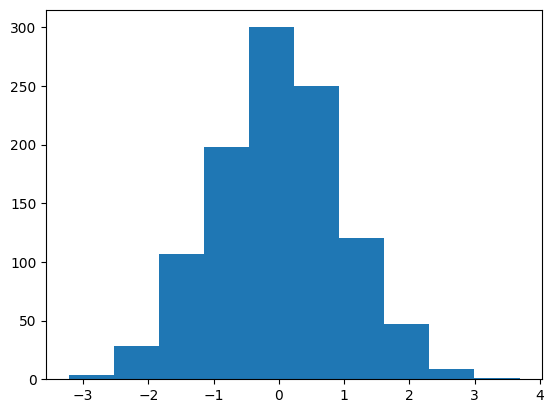

In [14]:
x_1 = np.random.normal(loc=0, scale=1, size=1064)
plt.hist(x_1);

In [15]:
# Queremos probar si el (0.5)-cuantil es 0
tester_1 = QuantileSignTest(x_1, 0, 0.5)

In [16]:
tester_1.run_test(alternative="x_p != n_p0")
tester_1.run_test(alternative="x_p < n_p0")
tester_1.run_test(alternative="x_p > n_p0")

H_0: x_(0.5) = 0 v.s H_a: x_(0.5) != 0
Rechazar H_0 si K <= 504 o K >= 560
Valor que tomó la estadística 543
-> No rechazamos H_0 con nivel de significancia 4.59%
H_0: x_(0.5) = 0 v.s H_a: x_(0.5) < 0
Rechazar H_0 si K <= 510
Valor que tomó la estadística 543
-> No Rechazamos H_0 con nivel de significancia 9.37%
H_0: x_(0.5) = 0 v.s H_a: x_(0.5) > 0
Rechazar H_0 si K >= 554
Valor que tomó la estadística 543
-> No rechazamos H_0 con nivel de significancia 9.37%


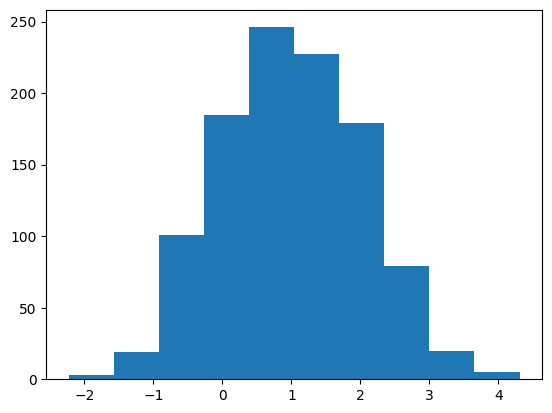

In [17]:
x_2 = np.random.normal(loc=1, scale=1, size=1064)
plt.hist(x_2);

In [18]:
# Queremos probar si el (0.5)-cuantil es 0, lo cual no es cierto.
tester_2 = QuantileSignTest(x_2, 0, 0.5)


In [19]:
tester_2.run_test(alternative="x_p != n_p0")
tester_2.run_test(alternative="x_p < n_p0")
tester_2.run_test(alternative="x_p > n_p0")

H_0: x_(0.5) = 0 v.s H_a: x_(0.5) != 0
Rechazar H_0 si K <= 504 o K >= 560
Valor que tomó la estadística 884
-> Rechazamos H_0 con nivel de significancia 4.59%
H_0: x_(0.5) = 0 v.s H_a: x_(0.5) < 0
Rechazar H_0 si K <= 510
Valor que tomó la estadística 884
-> No Rechazamos H_0 con nivel de significancia 9.37%
H_0: x_(0.5) = 0 v.s H_a: x_(0.5) > 0
Rechazar H_0 si K >= 554
Valor que tomó la estadística 884
-> Rechazamos H_0 con nivel de significancia 9.37%


#### Ejercicio 3 (Ayudantías)

In [20]:
data_3 = np.array([20, 35, 350, 120, 85, 345, 80, 320, 280, 85])
e_3 = SignTest(data_3, [0, 90, 270, 360])


In [21]:
e_3.run_test(alternative="P('+') != P('-')")
e_3.run_test(alternative="P('+') < P('-')")
e_3.run_test(alternative="P('+') > P('-')")

H_0: P('+') = P('-') v.s H_a: P('+') != P('-')
Rechazar H_0 si K <= 1 o K >= 9
Valor que tomó la estadística 9
-> Rechazamos H_0 con nivel de significancia 1.07%
H_0: P('+') = P('-') v.s H_a: P('+') < P('-')
Rechazar H_0 si K <= 2
Valor que tomó la estadística 9
-> No Rechazamos H_0 con nivel de significancia 5.47%
H_0: P('+') = P('-') v.s H_a: P('+') > P('-')
Rechazar H_0 si K >= 8
Valor que tomó la estadística 9
-> Rechazamos H_0 con nivel de significancia 5.47%
